In [ ]:
!pip install pandas numpy scikit-learn ta xgboost imblearn

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE



plt.style.use('default')
sns.set_theme()

In [ ]:
df = pd.read_excel('FinancialMarketData.xlsx', sheet_name='EWS')

In [ ]:
print(df.shape)
print(df.columns.tolist())
print(df.info())

(1111, 44)
['Y', 'Data', 'XAU BGNL', 'ECSURPUS', 'BDIY', 'CRY', 'DXY', 'JPY', 'GBP', 'Cl1', 'VIX', 'USGG30YR', 'GT10', 'USGG2YR', 'USGG3M', 'US0001M', 'GTDEM30Y', 'GTDEM10Y', 'GTDEM2Y', 'EONIA', 'GTITL30YR', 'GTITL10YR', 'GTITL2YR', 'GTJPY30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTGBP30Y', 'GTGBP20Y', 'GTGBP2Y', 'LUMSTRUU', 'LMBITR', 'LUACTRUU', 'LF98TRUU', 'LG30TRUU', 'LP01TREU', 'EMUSTRUU', 'LF94TRUU', 'MXUS', 'MXEU', 'MXJP', 'MXBR', 'MXRU', 'MXIN', 'MXCN']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Y          1111 non-null   int64         
 1   Data       1111 non-null   datetime64[ns]
 2   XAU BGNL   1111 non-null   float64       
 3   ECSURPUS   1111 non-null   float64       
 4   BDIY       1111 non-null   int64         
 5   CRY        1111 non-null   float64       
 6   DXY        1111 non-null   float64       
 7   JPY      


Class Distribution:
Y
0    0.786679
1    0.213321
Name: proportion, dtype: float64


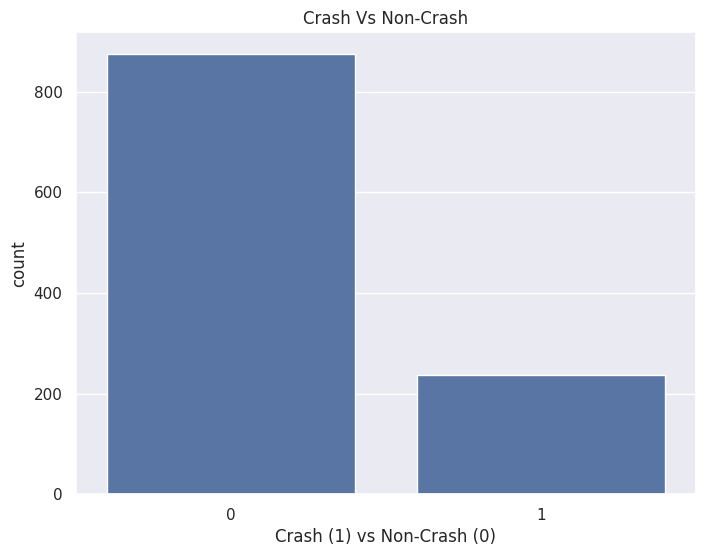

In [ ]:
print("\nClass Distribution:")
print(df['Y'].value_counts(normalize=True))

selected_features = ['XAU BGNL', 'DXY', 'VIX', 'USGG30YR', 'USGG3M', 'MXUS']

x=df[selected_features]
y=df['Y']

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Y')
plt.title('Crash Vs Non-Crash')
plt.xlabel('Crash (1) vs Non-Crash (0)')
plt.show()

In [ ]:
def create_features(df, selected_features):
    features = pd.DataFrame()

    for col in selected_features:
        features[f'{col}_Change'] = df[col].pct_change()
        features[f'{col}_MA20'] = df[col].rolling(window=20).mean()
        features[f'{col}_MA50'] = df[col].rolling(window=50).mean()
        features[f'{col}_Volatility'] = df[col].rolling(window=20).std()

    features['VIX_Crossover'] = (df['VIX'] < features['VIX_MA20']).astype(int)
    features['Yield_Spread'] = df['USGG30YR'] - df['USGG3M']
    features['Yield_Spread_Change'] = features['Yield_Spread'].pct_change()
    features['Gold_DXY_Corr'] = df['XAU BGNL'].rolling(window=20).corr(df['DXY'])
    features['VIX_Gold_Corr'] = df['VIX'].rolling(window=20).corr(df['XAU BGNL'])

    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(method='ffill').fillna(0)

    return features

X_enhanced = create_features(df, selected_features)
print("Enhanced feature set shape:", X_enhanced.shape)
print("\nFeatures created:", X_enhanced.columns.tolist())

Enhanced feature set shape: (1111, 29)

Features created: ['XAU BGNL_Change', 'XAU BGNL_MA20', 'XAU BGNL_MA50', 'XAU BGNL_Volatility', 'DXY_Change', 'DXY_MA20', 'DXY_MA50', 'DXY_Volatility', 'VIX_Change', 'VIX_MA20', 'VIX_MA50', 'VIX_Volatility', 'USGG30YR_Change', 'USGG30YR_MA20', 'USGG30YR_MA50', 'USGG30YR_Volatility', 'USGG3M_Change', 'USGG3M_MA20', 'USGG3M_MA50', 'USGG3M_Volatility', 'MXUS_Change', 'MXUS_MA20', 'MXUS_MA50', 'MXUS_Volatility', 'VIX_Crossover', 'Yield_Spread', 'Yield_Spread_Change', 'Gold_DXY_Corr', 'VIX_Gold_Corr']


<ipython-input-14-f88e036c68a1>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(0)


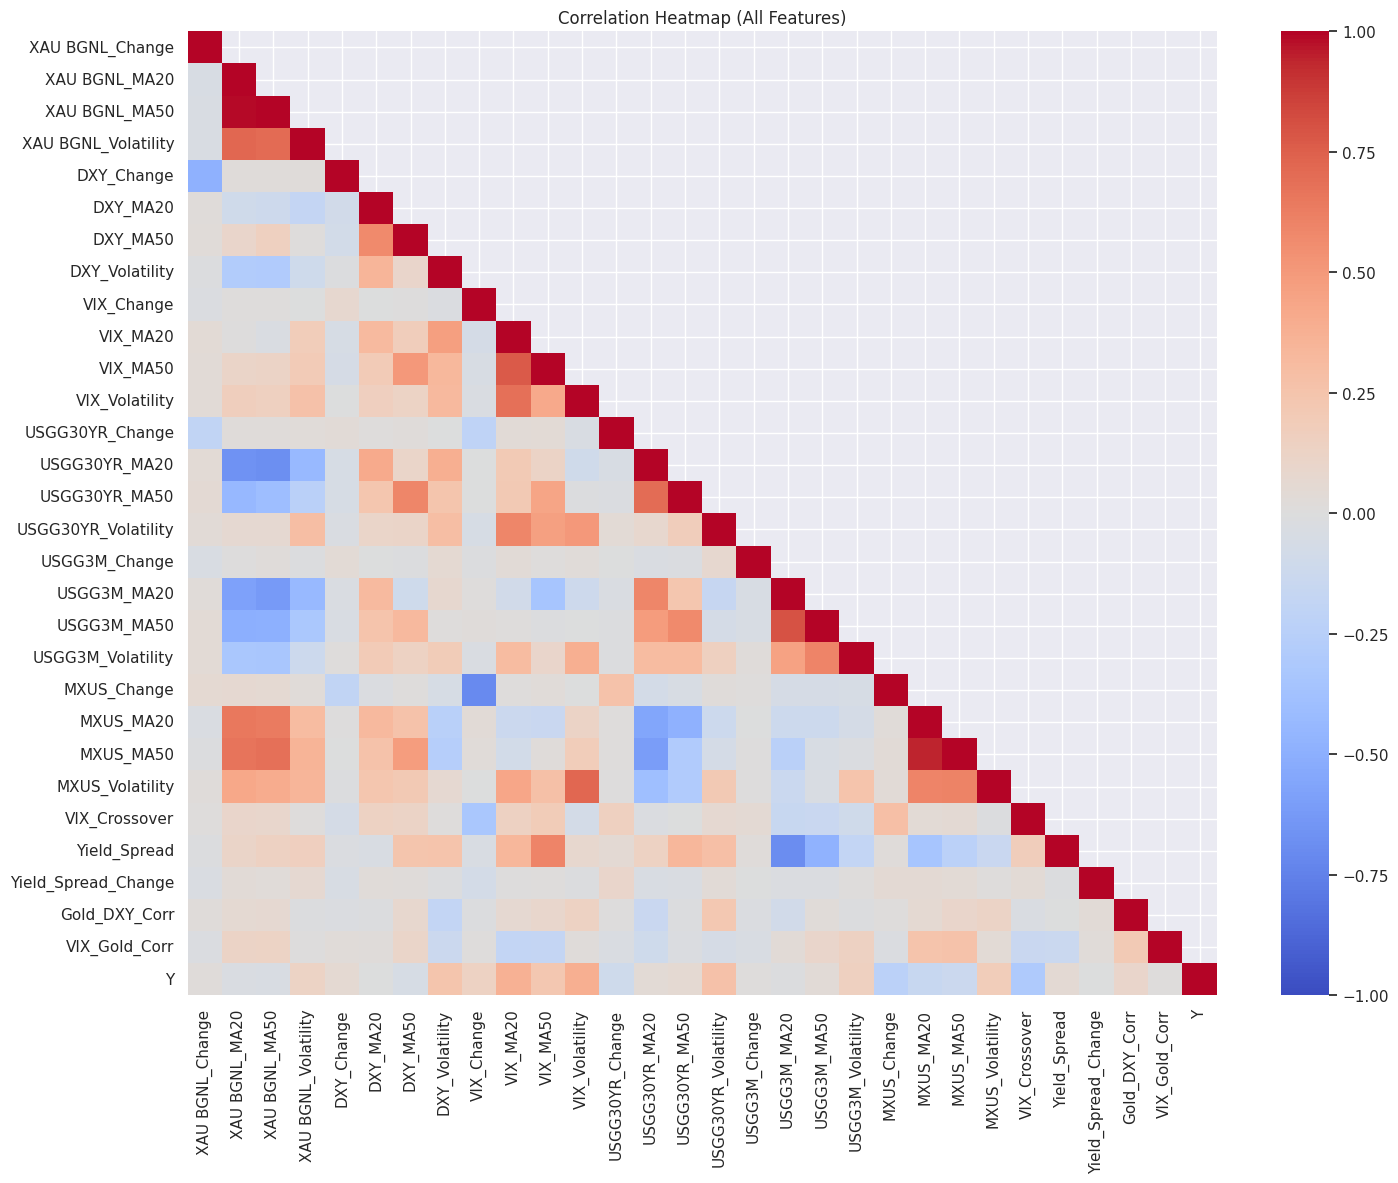

In [ ]:
all_features = X_enhanced.copy()
all_features['Y'] = y

corr_matrix = all_features.corr()
mask = np.triu(np.ones_like(corr_matrix), k=1)

plt.figure(figsize=(15, 12))  #
sns.heatmap(corr_matrix,
            mask=mask,
            annot=False,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)

plt.title('Correlation Heatmap (All Features)')
plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

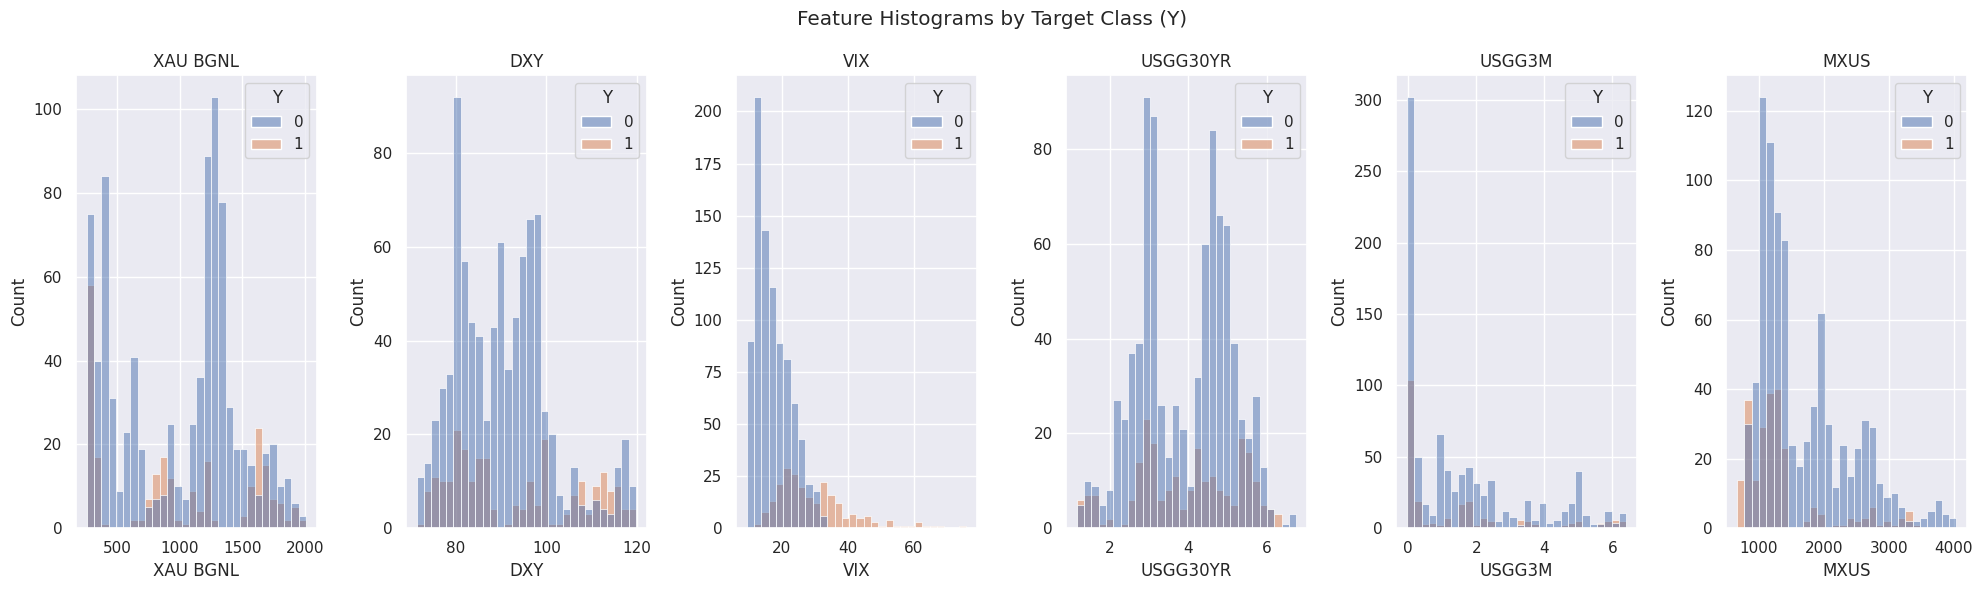

In [ ]:
cols_to_plot = selected_features  # ['XAU BGNL', 'DXY', 'VIX', 'USGG30YR', 'USGG3M', 'MXUS']

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(20, 6))
fig.suptitle('Feature Histograms by Target Class (Y)')

for i, col in enumerate(cols_to_plot):
    sns.histplot(
        data=df,
        x=col,
        hue='Y',
        ax=axes[i],
        multiple="layer",
        alpha=0.5,
        bins=30
    )
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

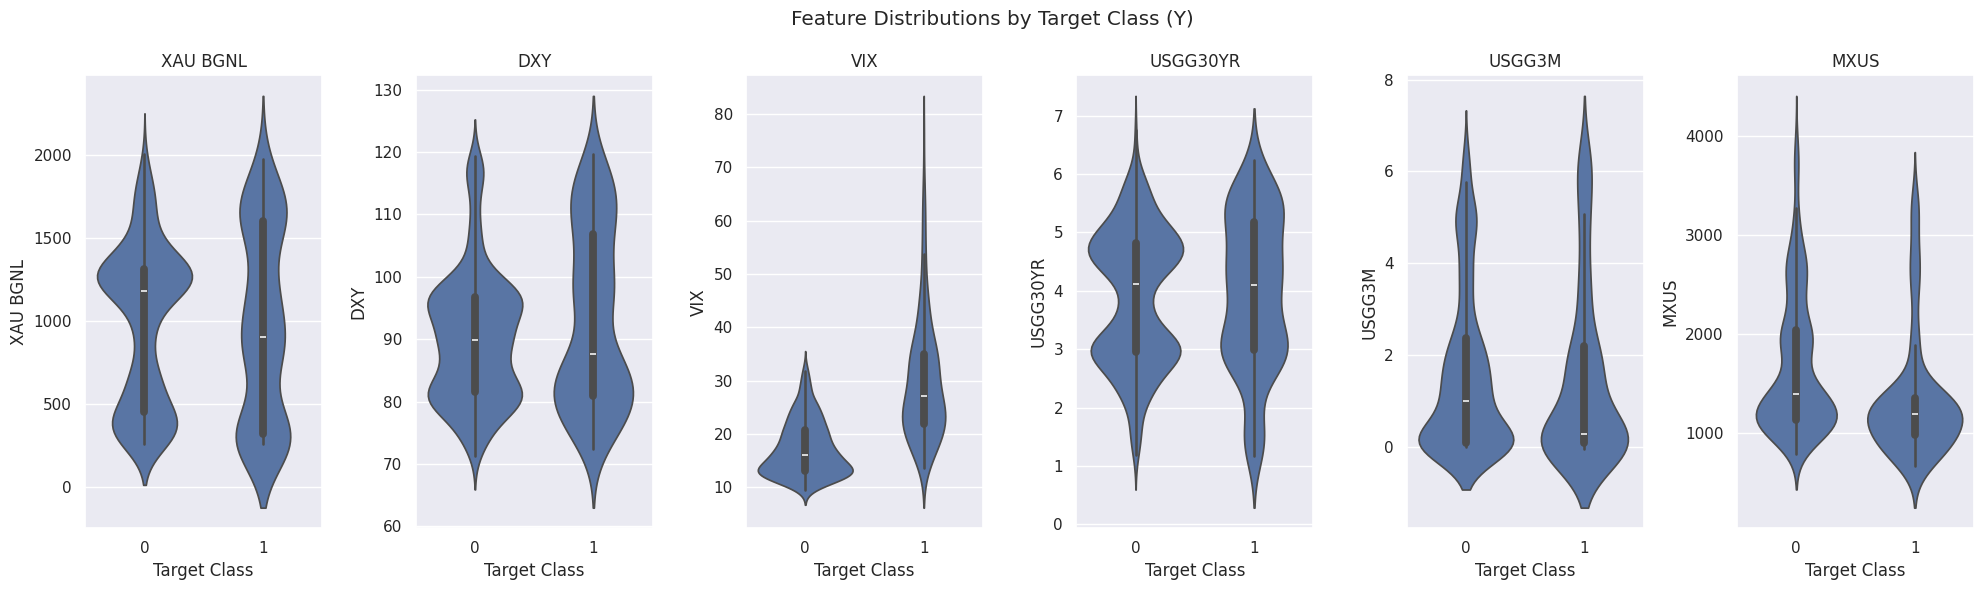

In [ ]:
plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(20, 6))
fig.suptitle('Feature Distributions by Target Class (Y)')

for i, col in enumerate(cols_to_plot):
    sns.violinplot(
        data=df,
        x='Y',
        y=col,
        ax=axes[i],
        inner='box'
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('Target Class')

plt.tight_layout()
plt.show()

In [ ]:

X_enhanced['Y'] = df['Y']

X = X_enhanced.drop('Y', axis=1)
y = X_enhanced['Y']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nOriginal training set shape:", X_train_scaled.shape)
print("Balanced training set shape:", X_train_balanced.shape)
print(pd.Series(y_train_balanced).value_counts(normalize=True))


Original training set shape: (888, 29)
Balanced training set shape: (1398, 29)
Y
0    0.5
1    0.5
Name: proportion, dtype: float64



Logistic Regression Results:
Accuracy: 0.848
Precision: 0.606
Recall: 0.833
F1 Score: 0.702


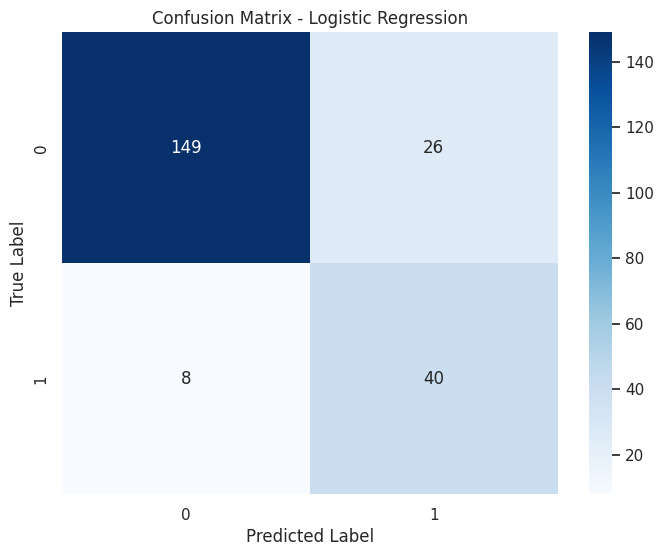


Random Forest Results:
Accuracy: 0.915
Precision: 0.764
Recall: 0.875
F1 Score: 0.816


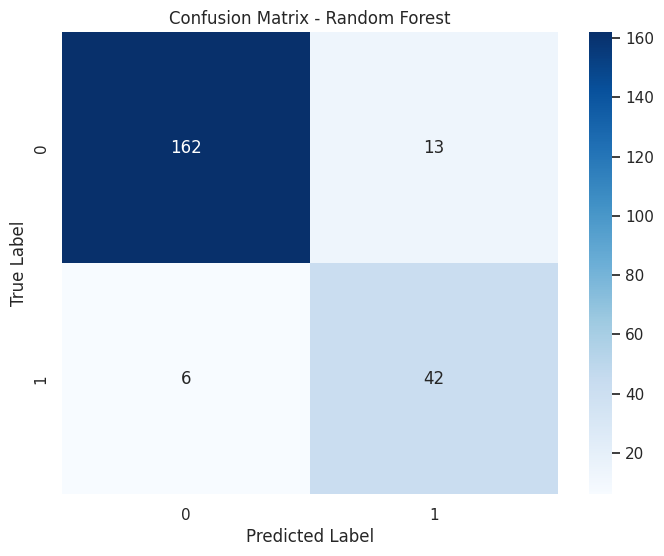


XGBoost Results:
Accuracy: 0.910
Precision: 0.759
Recall: 0.854
F1 Score: 0.804


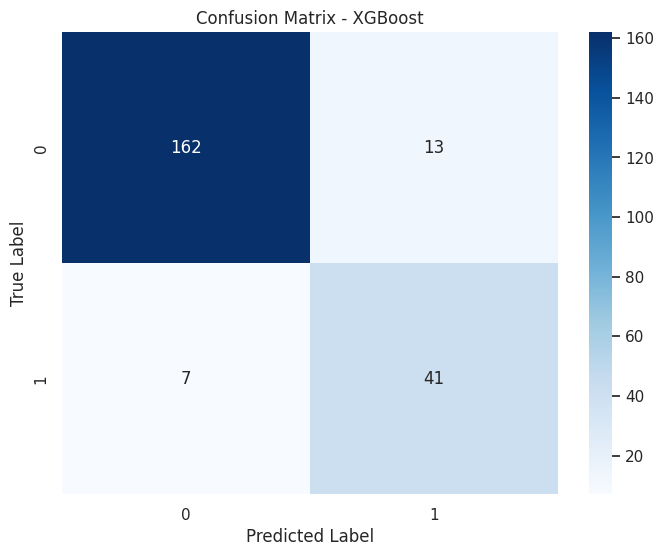

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    evaluate_model(y_test, y_pred, name)

# **Testing the model using Yahoo Finance API**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_test_data():
    start_date = '2022-01-01'
    end_date = '2024-01-01'


    data = pd.DataFrame()

    try:
        vix = yf.download('^VIX', start=start_date, end=end_date)['Close']
        data['VIX'] = vix

        dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date)['Close']
        data['DXY'] = dxy

        gold = yf.download('GC=F', start=start_date, end=end_date)['Close']
        data['XAU BGNL'] = gold

        sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
        data['MXUS'] = sp500

        treasury_30y = yf.download('^TYX', start=start_date, end=end_date)['Close']/10
        treasury_3m = yf.download('^IRX', start=start_date, end=end_date)['Close']
        data['USGG30YR'] = treasury_30y
        data['USGG3M'] = treasury_3m


    except Exception as e:
        print(f"Error getting data: {e}")

    return data

In [ ]:
recent_data = get_test_data()

print("\Data Preview: ")
print(recent_data.head())

print("\nMissing Values:")
print(recent_data.isnull().sum())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


\Data Preview: 
                  VIX        DXY     XAU BGNL         MXUS  USGG30YR  USGG3M
Date                                                                        
2022-01-03  16.600000  96.239998  1799.400024  4796.560059    0.2016   0.053
2022-01-04  16.910000  96.290001  1814.000000  4793.540039    0.2077   0.080
2022-01-05  19.730000  96.190002  1824.599976  4700.580078    0.2088   0.085
2022-01-06  19.610001  96.250000  1788.699951  4696.049805    0.2093   0.090
2022-01-07  18.760000  95.739998  1797.000000  4677.029785    0.2118   0.088

Missing Values:
VIX         0
DXY         0
XAU BGNL    0
MXUS        0
USGG30YR    0
USGG3M      0
dtype: int64


In [ ]:
selected_features = ['XAU BGNL', 'DXY', 'VIX', 'USGG30YR', 'USGG3M', 'MXUS']

X_recent = create_features(recent_data, selected_features)

X_recent_scaled = scaler.transform(X_recent)

print(X_recent.shape)
print(X_recent.columns.tolist())

(501, 29)
['XAU BGNL_Change', 'XAU BGNL_MA20', 'XAU BGNL_MA50', 'XAU BGNL_Volatility', 'DXY_Change', 'DXY_MA20', 'DXY_MA50', 'DXY_Volatility', 'VIX_Change', 'VIX_MA20', 'VIX_MA50', 'VIX_Volatility', 'USGG30YR_Change', 'USGG30YR_MA20', 'USGG30YR_MA50', 'USGG30YR_Volatility', 'USGG3M_Change', 'USGG3M_MA20', 'USGG3M_MA50', 'USGG3M_Volatility', 'MXUS_Change', 'MXUS_MA20', 'MXUS_MA50', 'MXUS_Volatility', 'VIX_Crossover', 'Yield_Spread', 'Yield_Spread_Change', 'Gold_DXY_Corr', 'VIX_Gold_Corr']


<ipython-input-14-f88e036c68a1>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(0)


In [ ]:
rf_model = models['Random Forest']
predictions = rf_model.predict(X_recent_scaled)
probabilities = rf_model.predict_proba(X_recent_scaled)

results = pd.DataFrame({
    'Date': recent_data.index,
    'Crash_Probability': probabilities[:, 1],
    'Prediction': ['Crash' if p > 0.5 else 'No Crash' for p in predictions]
})

pd.set_option('display.max_rows', None)
print(results)

          Date  Crash_Probability Prediction
0   2022-01-03               0.52      Crash
1   2022-01-04               0.86      Crash
2   2022-01-05               0.76      Crash
3   2022-01-06               0.65      Crash
4   2022-01-07               0.77      Crash
5   2022-01-10               0.63      Crash
6   2022-01-11               0.54      Crash
7   2022-01-12               0.60      Crash
8   2022-01-13               0.38   No Crash
9   2022-01-14               0.75      Crash
10  2022-01-18               0.66      Crash
11  2022-01-19               0.31   No Crash
12  2022-01-20               0.63      Crash
13  2022-01-21               0.38   No Crash
14  2022-01-24               0.68      Crash
15  2022-01-25               0.49   No Crash
16  2022-01-26               0.58      Crash
17  2022-01-27               0.16   No Crash
18  2022-01-28               0.52      Crash
19  2022-01-31               0.36   No Crash
20  2022-02-01               0.24   No Crash
21  2022-0

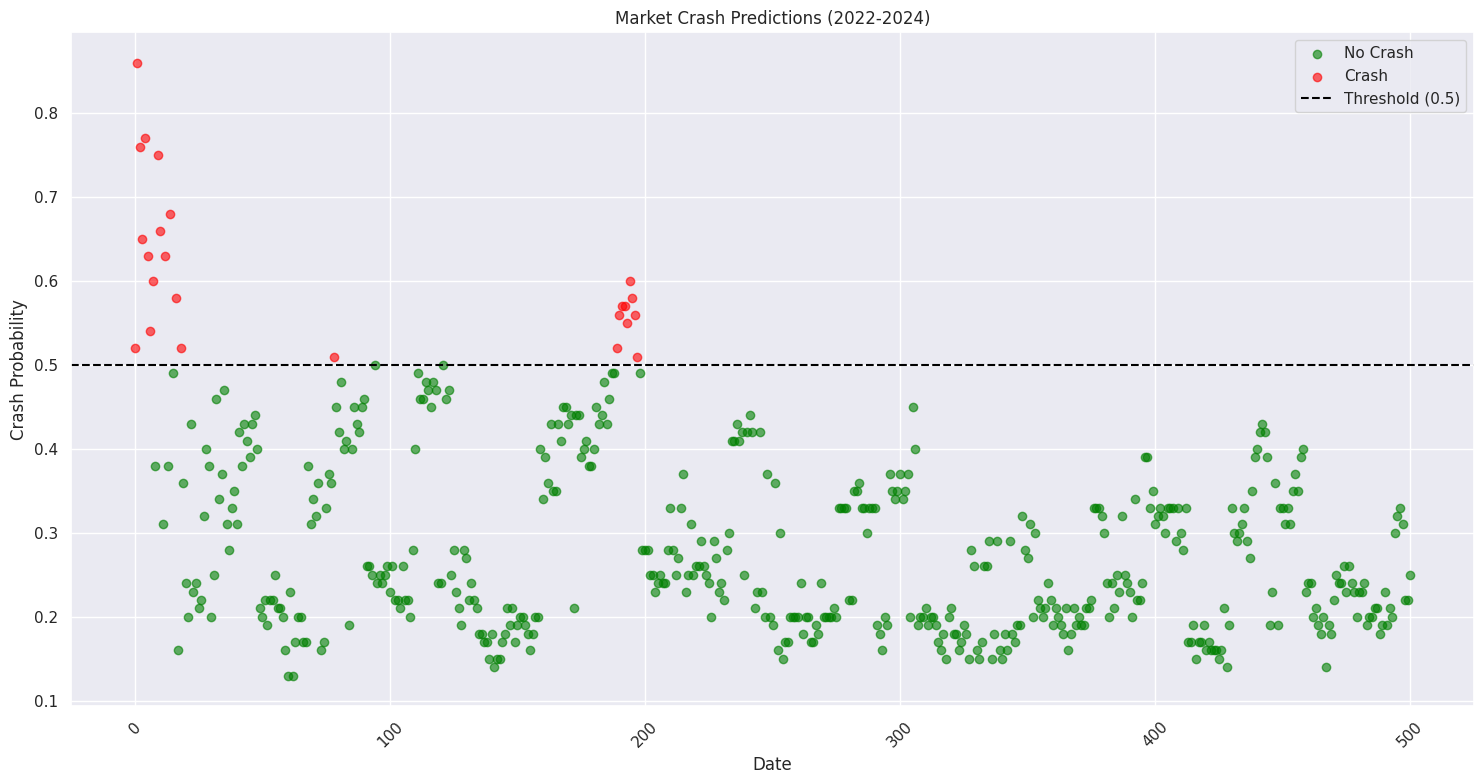

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(results.index[results['Prediction'] == 'No Crash'],
           results[results['Prediction'] == 'No Crash']['Crash_Probability'],
           c='green', label='No Crash', alpha=0.6)

plt.scatter(results.index[results['Prediction'] == 'Crash'],
           results[results['Prediction'] == 'Crash']['Crash_Probability'],
           c='red', label='Crash', alpha=0.6)

plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold (0.5)')

plt.title('Market Crash Predictions (2022-2024)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Crash Probability')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **Milestone 2: Trading Signals based On Predicted Crash Probabilities**

In [ ]:
def generate_trading_signals(results, market_data):
    strategy_df = pd.DataFrame(index=results.index)

    strategy_df['Crash_Probability'] = results['Crash_Probability']
    strategy_df['SPY'] = market_data['MXUS']
    strategy_df['Gold'] = market_data['XAU BGNL']
    strategy_df['Bonds'] = market_data['USGG30YR']

    def get_allocation(probability):
        if probability >= 0.6:  # Strong Sell - Most defensive
            return {'Signal': 'Strong Sell', 'SPY': 0, 'Gold': 0.3, 'Bonds': 0.4, 'Cash': 0.3}
        elif 0.4 <= probability < 0.6:  # Sell - Defensive
            return {'Signal': 'Sell', 'SPY': 0.2, 'Gold': 0.3, 'Bonds': 0.3, 'Cash': 0.2}
        elif 0.3 <= probability < 0.4:  # Hold - Balanced
            return {'Signal': 'Hold', 'SPY': 0.4, 'Gold': 0.3, 'Bonds': 0.2, 'Cash': 0.1}
        elif 0.2 <= probability < 0.3:  # Buy - Growth
            return {'Signal': 'Buy', 'SPY': 0.6, 'Gold': 0.2, 'Bonds': 0.2, 'Cash': 0}
        else:  # Strong Buy - Aggressive
            return {'Signal': 'Strong Buy', 'SPY': 0.8, 'Gold': 0.1, 'Bonds': 0.1, 'Cash': 0}

    allocations = strategy_df['Crash_Probability'].apply(get_allocation)
    strategy_df['Signal'] = allocations.apply(lambda x: x['Signal'])
    strategy_df['SPY_Allocation'] = allocations.apply(lambda x: x['SPY'])
    strategy_df['Gold_Allocation'] = allocations.apply(lambda x: x['Gold'])
    strategy_df['Bonds_Allocation'] = allocations.apply(lambda x: x['Bonds'])
    strategy_df['Cash_Allocation'] = allocations.apply(lambda x: x['Cash'])

    return strategy_df

signal_results = generate_trading_signals(results, recent_data)

latest = signal_results.iloc[-1]
print("\nCurrent Market Signal:")
print(f"Signal: {latest['Signal']}")
print(f"Crash Probability: {latest['Crash_Probability']:.2%}")

print("\nRecommended Asset Allocation:")
print(f"SPY: {latest['SPY_Allocation']:.1%}")
print(f"Gold: {latest['Gold_Allocation']:.1%}")
print(f"Bonds: {latest['Bonds_Allocation']:.1%}")
print(f"Cash: {latest['Cash_Allocation']:.1%}")

print("\nSignal Distribution:")
signal_counts = signal_results['Signal'].value_counts()
for signal, count in signal_counts.items():
    percentage = (count / len(signal_results)) * 100
    print(f"{signal}: {count} days ({percentage:.1f}%)")


Current Market Signal:
Signal: Buy
Crash Probability: 25.00%

Recommended Asset Allocation:
SPY: 60.0%
Gold: 20.0%
Bonds: 20.0%
Cash: 0.0%

Signal Distribution:
Buy: 192 days (38.3%)
Hold: 106 days (21.2%)
Strong Buy: 106 days (21.2%)
Sell: 86 days (17.2%)
Strong Sell: 11 days (2.2%)


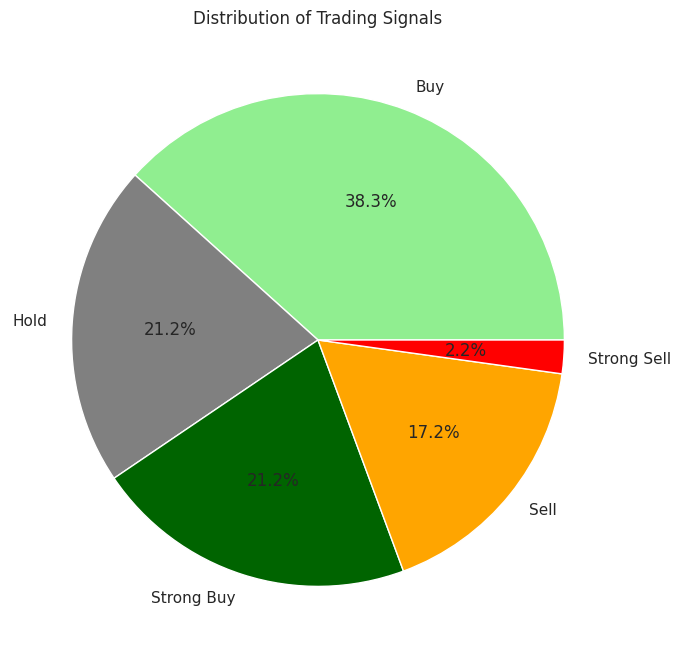

In [ ]:
plt.figure(figsize=(10, 8))
colors = {'Strong Buy': 'darkgreen', 'Buy': 'lightgreen',
          'Hold': 'gray', 'Sell': 'orange', 'Strong Sell': 'red'}
plt.pie(signal_counts.values, labels=signal_counts.index, autopct='%1.1f%%',
        colors=[colors[signal] for signal in signal_counts.index])
plt.title('Distribution of Trading Signals')
plt.show()

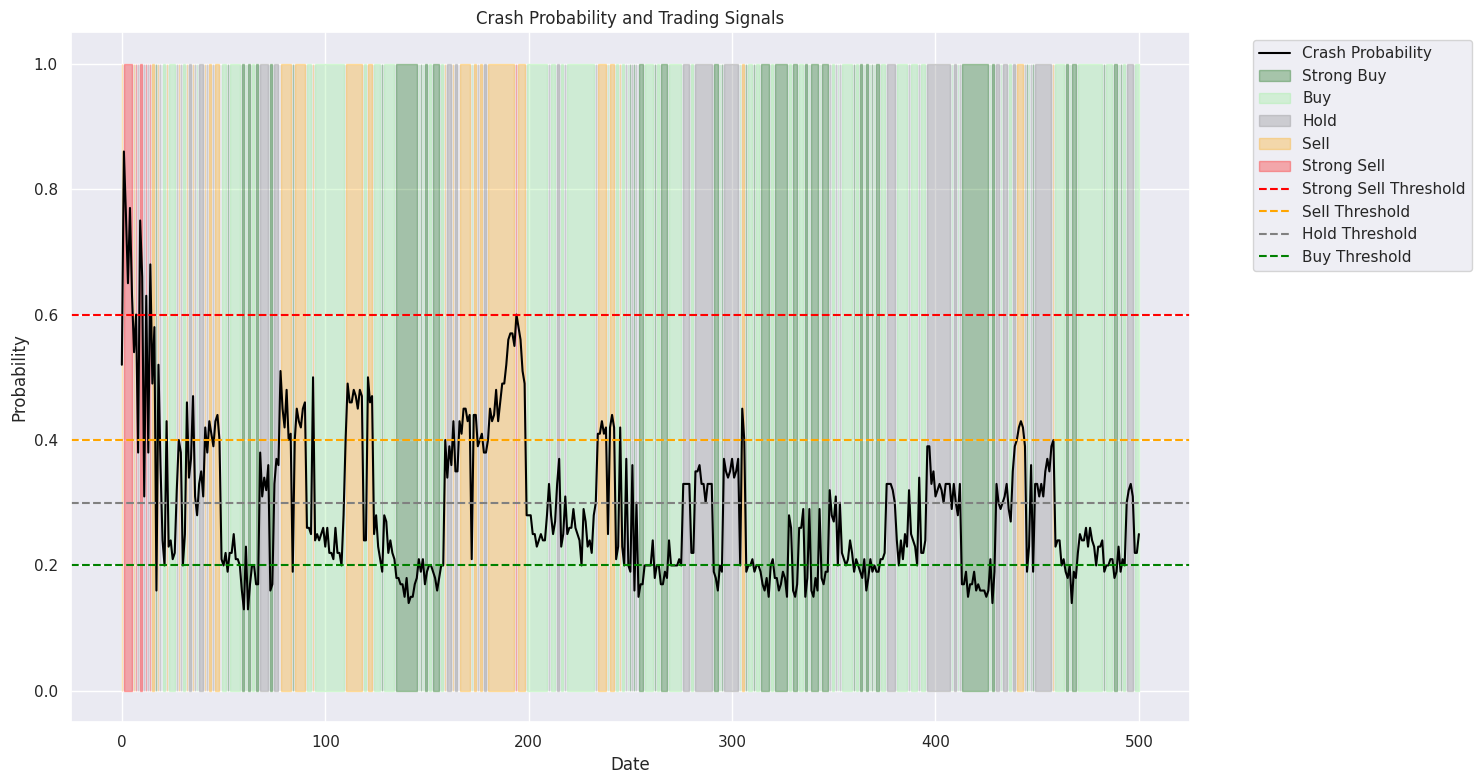

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(signal_results.index, signal_results['Crash_Probability'],
         color='black', label='Crash Probability')
for signal, color in colors.items():
    mask = signal_results['Signal'] == signal
    plt.fill_between(signal_results.index, 0, 1,
                     where=mask, color=color, alpha=0.3, label=signal)

plt.axhline(y=0.6, color='red', linestyle='--', label='Strong Sell Threshold')
plt.axhline(y=0.4, color='orange', linestyle='--', label='Sell Threshold')
plt.axhline(y=0.3, color='gray', linestyle='--', label='Hold Threshold')
plt.axhline(y=0.2, color='green', linestyle='--', label='Buy Threshold')

plt.title('Crash Probability and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

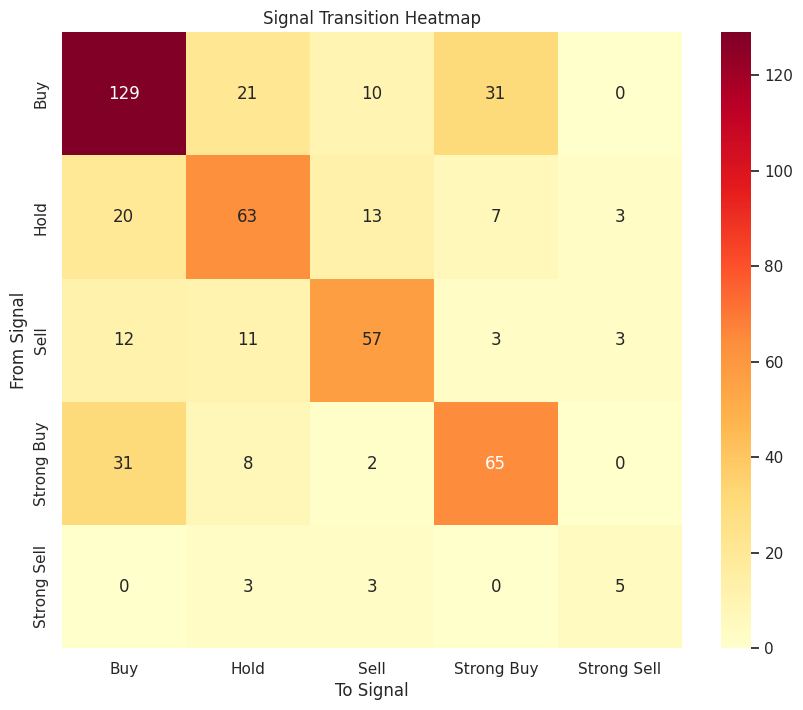

In [ ]:
transitions = pd.crosstab(signal_results['Signal'].shift(),
                         signal_results['Signal'])

plt.figure(figsize=(10, 8))
sns.heatmap(transitions, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Signal Transition Heatmap')
plt.xlabel('To Signal')
plt.ylabel('From Signal')
plt.show()

# **Milestone 3: AI-Driven Chat Investment Strategy Chat Bot**

In [ ]:
!pip install google-generativeai

In [ ]:
import google.generativeai as genai
from IPython.display import display, Markdown
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-2.0-flash-exp')

system_prompt = """You are an Investment Strategy Assistant specializing in market crash predictions and portfolio allocation.
You have access to our current market analysis and recommendations:

Current Market Analysis:
- Signal: Buy
- Crash Probability: 25.00%

Recommended Portfolio:
- SPY (Stocks): 60.0%
- Gold: 20.0%
- Bonds: 20.0%
- Cash: 0.0%

Historical Signal Distribution (2022-2024):
- Buy: 38.3% of the time
- Hold: 21.2% of the time
- Strong Buy: 21.2% of the time
- Sell: 17.2% of the time
- Strong Sell: 2.2% of the time

Your role is to:


ALWAYS FOLLOW THESE GUIDELINES IN ** **

**
1. Explain our investment strategy in clear, simple terms
2. Interpret current market signals and recommendations
3. Help users understand the allocation strategy
4. Provide context for risk levels and market conditions

When responding:
- Be clear and concise
- Use simple language
- Explain the reasoning behind recommendations
- Focus on actionable insights
- Acknowledge both opportunities and risks
**
"""

def get_llm_response(user_input):
    prompt = f"{system_prompt}\n\nUser: {user_input}\nAssistant:"
    response = model.generate_content(prompt)
    display(Markdown(f"**User:** {user_input}\n\n**Assistant:** {response.text}"))


while True:
    user_input = input("\nYou (type 'exit' to end): ")
    get_llm_response(user_input)


You (type 'exit' to end): what is the market forecast? given the signals? and how show my portfolio allocation be?


**User:** what is the market forecast? given the signals? and how show my portfolio allocation be?

**Assistant:** Okay, let's break down the current market forecast and your recommended portfolio allocation.

**Current Market Outlook**

Our current market signal is a "**Buy**". This suggests that our analysis indicates a positive outlook for the market in the near term. We see more potential for prices to go up rather than down. However, it's important to remember that even with a "Buy" signal, there is still a **25% probability of a market crash.** This means that while we are optimistic, we are aware of the potential risks. 

**Recommended Portfolio Allocation**

Given this outlook, our recommended portfolio allocation is as follows:

*   **SPY (Stocks): 60%** -  We're allocating the majority of your portfolio to stocks (represented by SPY, which tracks the S&P 500). This is because stocks are generally expected to perform well in a positive market environment.
*   **Gold: 20%** -  We recommend holding a significant portion in gold. Gold is often seen as a safe haven during uncertain times, so it can help protect your portfolio if the market takes an unexpected turn.
*  **Bonds: 20%** - We recommend holding some bonds, these tend to be more stable than stocks and can help reduce your overall portfolio volatility. 
*   **Cash: 0%** -  We currently suggest holding no cash. This indicates we don't see a need to move to the sidelines at this moment, but are taking the risk into account with safe-haven assets.

**Understanding the Strategy**

Essentially, we are currently positioned for growth while still maintaining a level of safety. We're leaning towards stocks, but we have a good allocation in gold and bonds as a safety net should the market crash unexpectedly.

**Historical Context & Risk**

It is important to note the historical distribution of our signals.  "Buy" signals occur 38.3% of the time, meaning that we have other signals occur more than 60% of the time. This is not an extremely common signal, but it is the most common we have.  However, with a 25% crash probability, it shows the importance of holding some safe-haven assets as well.

**Actionable Insights**

*   **Opportunity:** The current "Buy" signal suggests a potential for your portfolio to grow.
*   **Risk:** The 25% crash probability highlights the importance of diversification and the need for safe-haven assets.

**In summary:** We're optimistic but cautious. We're positioned for potential gains, but we are ready for potential downsides.
